In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_plot = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_Plot_tuneby_Plot_tmp.csv')
df_spatial = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_spatial_tuneby_spatial_tmp.csv')
df_ecosite = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_ecosite_tuneby_ecosite_tmp.csv')
df_year = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_Year_tuneby_Year_tmp.csv')

t_plot = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_Plot_tuneby_Plot_results_plot.csv')
t_spatial = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_spatial_tuneby_spatial_results_plot.csv')
t_ecosite = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_ecosite_tuneby_ecosite_results_plot.csv')
t_year = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_Year_tuneby_Year_results_plot.csv')

In [5]:
df_plot['cv'] = 'Plot'
df_spatial['cv'] = 'Spatial'
df_ecosite['cv'] = 'Ecosite'
df_year['cv'] = 'Year'

t_plot['cv'] = 'Plot'
t_spatial['cv'] = 'Spatial'
t_ecosite['cv'] = 'Ecosite'
t_year['cv'] = 'Year'

In [40]:
t_all = pd.concat([t_plot, t_spatial, t_ecosite, t_year])

In [41]:
t_all = t_all[t_all['Source'].isin(['OLS', 'LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'GBR'])].copy()

In [42]:
mod_name_dict = {
    'OLS': 'Linear: OLS',
    'LASSO': 'Linear: OLS',
    'PLS': 'Linear: PC',
    'PCR': 'Linear: PC',
    'SVR': 'Linear: SVR',
    'RF': 'Non-parametric: DT',
    'GBR': 'Non-parametric: DT'
}

In [43]:
t_all['Source_type'] = t_all['Source'].apply(lambda x: mod_name_dict[x])

In [44]:
t_all['cv'] = t_all['cv'].apply(lambda x: 'Pasture (block)' if x == 'Spatial' else 'Plot (random)' if x == 'Plot' else x)

In [45]:
t_all.columns

Index(['Source', 'MAE', 'MAE_std', 'Bias', 'Bias_std', 'R^2', 'R^2_std', 'r',
       'r_std', 'MAE_bt', 'MAE_bt_std', 'MAE_bt_pct', 'MAE_bt_pct_std',
       'Bias_bt', 'Bias_bt_std', 'cv', 'Source_type'],
      dtype='object')

## Aggregated models

<Axes: xlabel='cv', ylabel='R^2'>

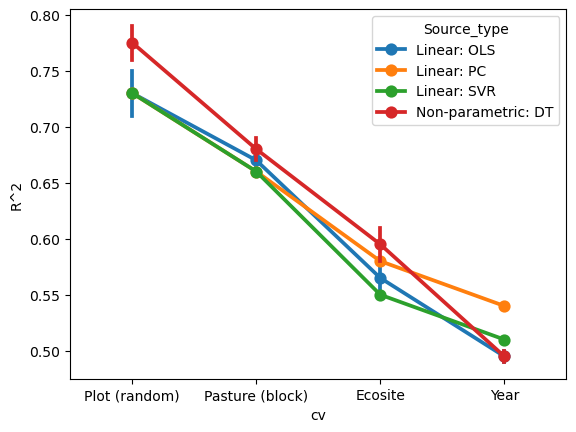

In [46]:
sns.pointplot(x='cv', y='R^2', data=t_all, hue='Source_type')

<Axes: xlabel='cv', ylabel='r'>

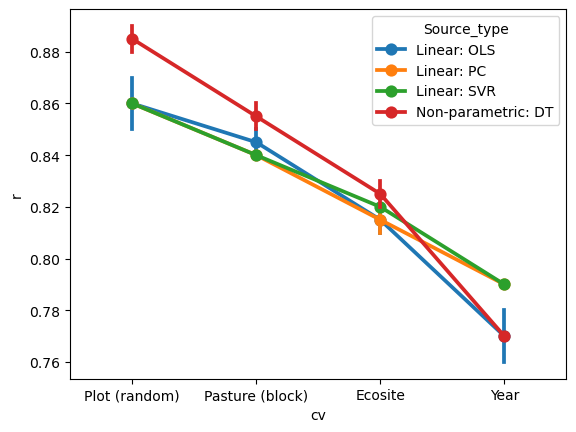

In [47]:
sns.pointplot(x='cv', y='r', data=t_all, hue='Source_type')

<Axes: xlabel='cv', ylabel='MAE_bt_pct'>

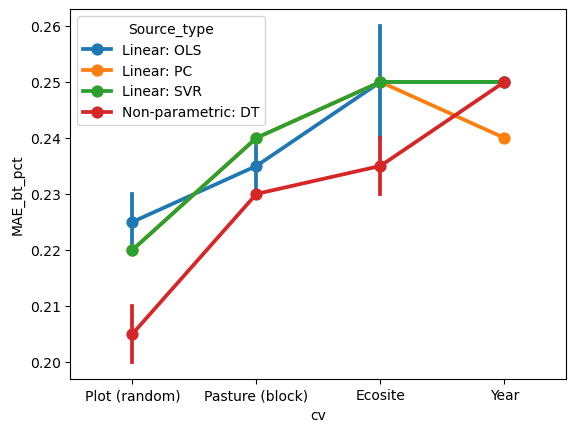

In [48]:
sns.pointplot(x='cv', y='MAE_bt_pct', data=t_all, hue='Source_type')

## PLS/PCA bi-plots

In [49]:
#https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib as mpl

In [50]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [51]:
var_names = ['NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']

In [52]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
import re

In [123]:
def plot_pcs(df, ax, var_names, pc_type, var_reduce_type, k, vars_of_interest, title=None):    
    # load data
    X = df[var_names]
    y = df['sqrt_Biomass_kg_ha']
    features = var_names
    X_scaled = StandardScaler().fit_transform(X)
    
    if pc_type == 'pca':
        features +=  ['sqrt_Biomass_kg_ha']
        # analysis
        pca = PCA(n_components=10).fit(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        X_reduced = pca.transform(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        # results
        scores = X_reduced[:, :2]
        loadings = pca.components_[:2].T
        pvars = pca.explained_variance_ratio_[:2] * 100
    elif pc_type == 'pls':
        pls2 = PLSRegression(n_components=10)
        pls2.fit(X_scaled, y)
        loadings = pls2.x_loadings_[:,:2]
        scores = pls2.x_scores_[:, :2]
        naY = y
        r2_scores = []
        for i in range(0,10):
            Y_pred=np.dot(pls2.x_scores_[:,i].reshape(-1,1),pls2.y_loadings_[:,i].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
            r2_scores.append(round(r2_score(y,Y_pred),3))
        pvars = np.array(r2_scores[:2])*100
    
    if var_reduce_type == 'top_k':
        k = 2
        tops = (loadings ** 2).sum(axis=1).argsort()[-k:]
    elif var_reduce_type == 'manual':
        tops = [i for i, value in enumerate(features) if value in vars_of_interest]
    
    if pc_type == 'pca':
        tops = [x for x in tops if (x+1) != len(features)]
    arrows = loadings[tops]
    arrows /= np.sqrt((arrows ** 2).sum(axis=0))
    arrows *= np.abs(scores).max(axis=0)
    
    if pc_type == 'pca':
        bm_arrow = loadings[-1]
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
    elif pc_type == 'pls':
        bm_arrow = pls2.y_loadings_[:,:2].squeeze()
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
        #bm_arrow *= np.abs(pls2.y_scores_).max(axis=0)
    
    for idx, i in enumerate(range(scores.shape[1])):
        df['PC'+str(i+1)] = scores[:,i]
    
    pcs = [1,2]
    #plt.scatter(scores[:, 0], scores[:,1], s=8, alpha=0.5)
    sns.scatterplot(x='PC'+str(pcs[0]), y='PC'+str(pcs[1]), data=df, hue='Season',
                    edgecolor='none', alpha=0.3, s=6, palette='Greys', ax=ax)
    #ax.legend(title=None, loc='lower center', ncols=5)
    width = -0.005 * np.min([np.subtract(*ax.get_xlim()), np.subtract(*ax.get_ylim())])
    for i, arrow in zip(tops, arrows):
        ax.arrow(0, 0, *arrow, color='k', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
        ax.text(*(arrow * 1.3), features[i], ha='center', va='center', color='k')
    ax.arrow(0, 0, *bm_arrow, color='grey', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
    ax.text(*(bm_arrow * 1.2), 'Biomass', ha='center', va='center', color='grey')

    ax.set_xlim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    ax.set_ylim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    
    for i, axis in enumerate('xy'):
        #getattr(plt, f'{axis}ticks')([])
        getattr(ax, f'set_{axis}label')(f'PC{i + 1} ({pvars[i]:.2f}%)')
    custom_lines = []
    kfold_labels = []
    for i, k in enumerate(df['kfold'].sort_values().unique()):
        custom_lines.append(Line2D([0], [0], 
                                   color=mpl.colormaps['tab10'].colors[i],
                                   lw=4))
        confidence_ellipse(df['PC'+str(pcs[0])][df['kfold'] == k], 
                           df['PC'+str(pcs[1])][df['kfold'] == k], 
                           ax,
                           edgecolor=mpl.colormaps['tab10'].colors[i])
        if type(k) == np.float_:
            kfold_labels.append(str(int(k)))
        elif 'kfold' in k:
            kfold_labels.append(re.sub('kfold', '', k))
        else:
            kfold_labels.append(str(k))
    ax.legend(custom_lines, kfold_labels, frameon=False)
    ax.set_title(title, y=1.0)
    return ax

In [124]:
names = ['Plot (random)', 'Pasture (block)', 'Ecosite', 'Year']

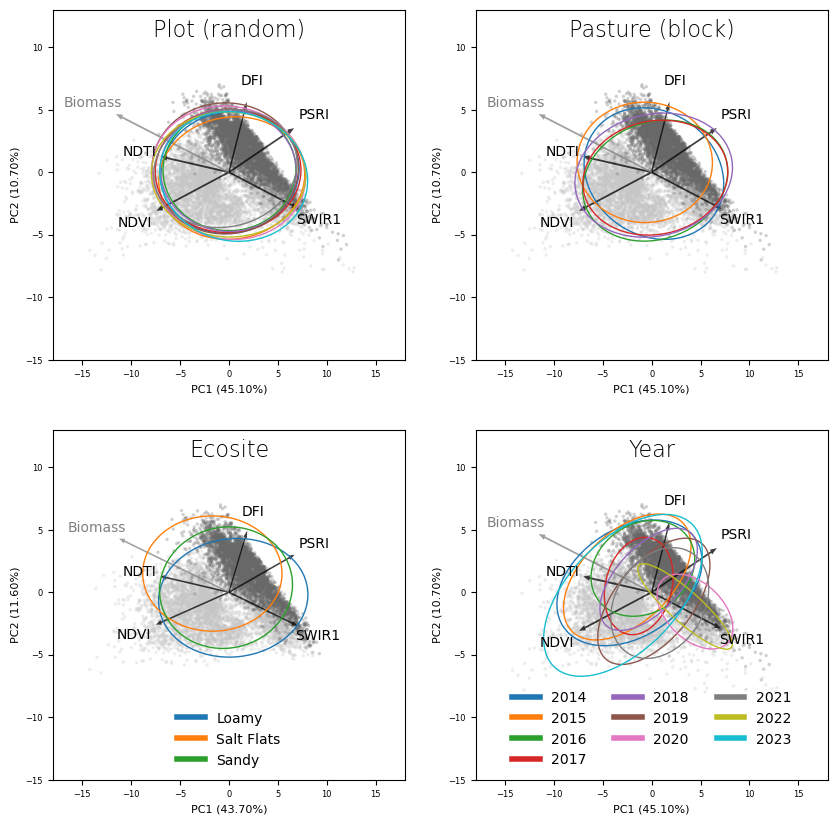

In [131]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for idx, df in enumerate([df_plot, df_spatial, df_ecosite, df_year]):
    df['sqrt_Biomass_kg_ha'] = np.sqrt(df['Biomass_kg_ha']) 
    plot_pcs(df=df,
             ax=axs.flatten()[idx],
             var_names=var_names,
             pc_type = 'pls',
             var_reduce_type = 'manual',
             k=None,
             vars_of_interest = ['NDVI', 'DFI', 'NDTI', 'SWIR1', 'PSRI'],
             #vars_of_interest = ['SWIR2', 'NDTI', 'TCWI', 'SWIR1', 'BLUE', 'TCBI', 'GREEN', 'DFI', 'RED'],
             title=names[idx])
    leg = axs.flatten()[idx].get_legend()
    if idx > 1:
        leg.set_loc('lower center')
        if idx == 3:
            #handles, labels = axs.flatten()[idx].get_legend_handles_labels()
            axs.flatten()[idx].legend(leg.legend_handles,
                                      [x.get_text() for x in leg.get_texts()], 
                                      ncol=3, loc='lower center', frameon=False)
    else:
        leg.set_visible(False)
for ax in axs.flatten():
    ax.title.set(fontweight=10, fontsize=16, y=0.9)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    ax.set_xlim((-18, 18))
    ax.set_ylim((-15, 13))

## Individual models

<Axes: xlabel='cv', ylabel='R^2'>

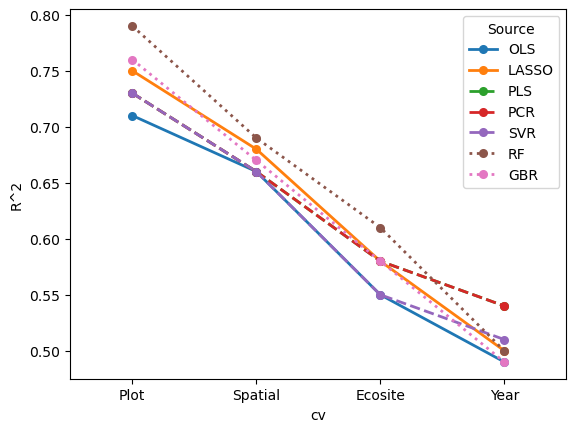

In [8]:
sns.pointplot(x='cv', y='R^2', data=t_all, hue='Source',
              linestyles=['solid', 'solid', 'dashed', 'dashed', 'dashed', 'dotted', 'dotted'],
              linewidth=2)

<Axes: xlabel='cv', ylabel='MAE_bt'>

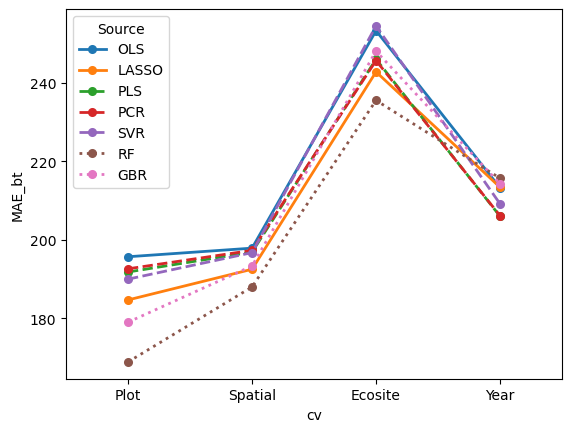

In [9]:
sns.pointplot(x='cv', y='MAE_bt', data=t_all, hue='Source',
              linestyles=['solid', 'solid', 'dashed', 'dashed', 'dashed', 'dotted', 'dotted'],
              linewidth=2)

<Axes: xlabel='cv', ylabel='MAE_bt_pct'>

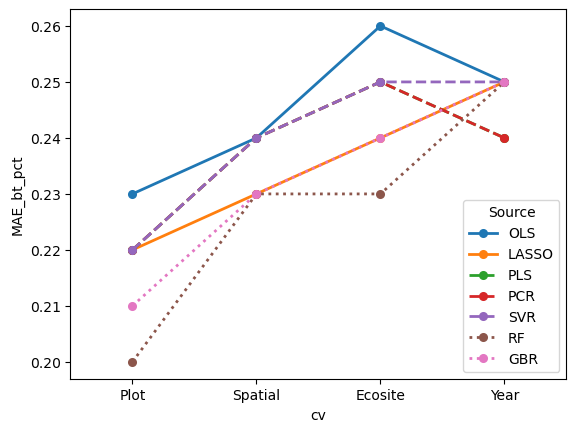

In [10]:
sns.pointplot(x='cv', y='MAE_bt_pct', data=t_all, hue='Source',
              linestyles=['solid', 'solid', 'dashed', 'dashed', 'dashed', 'dotted', 'dotted'],
              linewidth=2)

<Axes: xlabel='cv', ylabel='r'>

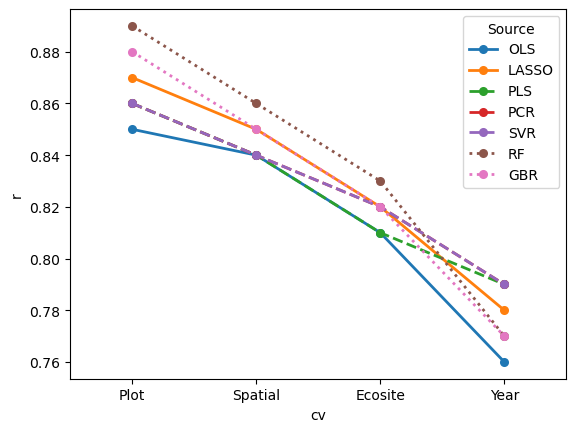

In [11]:
sns.pointplot(x='cv', y='r', data=t_all, hue='Source',
              linestyles=['solid', 'solid', 'dashed', 'dashed', 'dashed', 'dotted', 'dotted'],
              linewidth=2)